## Covid-19 Forecasting Project

A forecasting model for Covid-19 deaths was created using Prophet - an open source library published by facebook. The model uses confirmed positive cases as a predictor variable for deaths in each state

In [1]:
import pandas as pd  
import numpy as np  
import os
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
#run this cell twice
class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

with suppress_stdout_stderr(): 
    from fbprophet import Prophet

## Import Data from https://covidtracking.com/data/download

In [4]:
states_url = 'https://covidtracking.com/data/download/all-states-history.csv'
states_data = pd.read_csv(states_url) 

In [5]:
states_data

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,20200908,WY,A,42.0,NaN,0,NaN,219.0,219.0,17.0,...,81469.0,3125,NaN,NaN,NaN,NaN,80849.0,3164,117914.0,6523
1,20200908,NE,A+,404.0,NaN,0,NaN,2079.0,2079.0,172.0,...,378300.0,839,NaN,NaN,NaN,NaN,378793.0,854,NaN,0
2,20200908,ND,A,129.0,125.0,4,4.0,604.0,604.0,63.0,...,212129.0,231,8918.0,NaN,NaN,NaN,212129.0,231,508555.0,1253
3,20200908,NC,A+,2909.0,2909.0,12,NaN,NaN,NaN,827.0,...,2469977.0,10395,NaN,NaN,NaN,NaN,NaN,0,2469977.0,10395
4,20200908,MT,B,119.0,NaN,1,NaN,502.0,502.0,161.0,...,268780.0,1655,NaN,NaN,NaN,NaN,NaN,0,268780.0,1655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,20200124,WA,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0
10566,20200123,WA,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0
10567,20200123,MA,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,NaN,NaN,0,2.0,1
10568,20200122,WA,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0


Combine all positive cases and deaths for each state AND date

In [6]:
deaths_project = states_data.groupby(['date','state'], as_index=False).sum()
deaths_project.rename(columns={'date':'ds', 'deathIncrease':'y'}, inplace=True)
deaths_project['ds'] = deaths_project['ds'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
deaths_project

,ds,state,death,deathConfirmed,y,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2020-01-22,MA,0.0,0.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,1
1,2020-01-22,WA,0.0,0.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
2,2020-01-23,MA,0.0,0.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,2.0,1
3,2020-01-23,WA,0.0,0.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
4,2020-01-24,MA,0.0,0.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,2020-09-08,VT,58.0,58.0,0,0.0,0.0,0.0,4.0,0,...,146782.0,789,0.0,0.0,0.0,0.0,146782.0,789,0.0,0
10566,2020-09-08,WA,1953.0,1953.0,0,0.0,6860.0,6860.0,277.0,0,...,1563053.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
10567,2020-09-08,WI,1176.0,1168.0,0,8.0,6118.0,6118.0,298.0,29,...,1317836.0,4115,0.0,0.0,0.0,0.0,1312636.0,4083,0.0,0
10568,2020-09-08,WV,250.0,248.0,3,2.0,0.0,0.0,152.0,0,...,462760.0,995,16139.0,0.0,0.0,0.0,0.0,0,462547.0,989


Create data frame with positive coronavirus increases and date for each state. This will be used to create regressor values in the Prophet model later.

In [7]:
columns = ['positiveIncrease', 'state', 'ds']
positiveIncrease_df = deaths_project[columns]
positiveIncrease_df

,positiveIncrease,state,ds
0,0,MA,2020-01-22
1,0,WA,2020-01-22
2,0,MA,2020-01-23
3,0,WA,2020-01-23
4,0,MA,2020-01-24
...,...,...,...
10565,3,VT,2020-09-08
10566,0,WA,2020-09-08
10567,749,WI,2020-09-08
10568,86,WV,2020-09-08


## Build Prophet Model

Covid-19 deaths is often described as a "lagging indicator" to confirmed positive cases as it takes several weeks after diagnosis for patients to die. The Harvard School of Public Health demonstrated in a working paper that deaths often occur 2-8 weeks after the onset of Covid-19 symptoms.  

To account for this variable range in lag between cases and deaths, the Prophet Model will include a 5-day moving average of reported positive coronavirus cases as regressor values. This value is then shifted 21 days to compare deaths with the reported cases 3 weeks prior. 

Model Diagnostics are included in the last section of notebook (in progress).

In [8]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 5-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=21, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 21 days 
    future['Moving_Average'] = future['Moving_Average'].shift(21)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    # Calculate Mean Absolute Error for each state and append to a list
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


[[]]

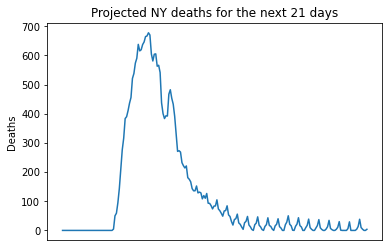

In [9]:
deaths_project_df[deaths_project_df < 0] = 0
deaths_project_df.reset_index(level=0, inplace=True)

ax = sns.lineplot(x="ds", y="yhat_NY", data = deaths_project_df)
ax.set_title('Projected NY deaths for the next 21 days')
ax.set_xlabel('')
ax.set_ylabel('Deaths')
ax.set(xticks=[])

Due to how deaths are reported, the graphs are often oscillating with the crest occuring mid-week and trough on the weekends. To smooth the graph, the 7-day moving average will be calculated

[[]]

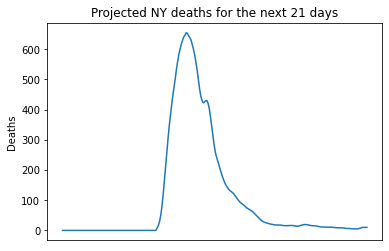

In [11]:
#Create 7-day moving average to smooth graph
deaths_project_FINAL = deaths_project_df
deaths_project_FINAL = deaths_project_FINAL.fillna(0)
deaths_project_FINAL = deaths_project_FINAL.set_index('ds')
deaths_project_FINAL = deaths_project_FINAL.rolling(window=7).mean()
deaths_project_FINAL = deaths_project_FINAL.reset_index()
deaths_project_FINAL = deaths_project_FINAL.fillna(0)

ax = sns.lineplot(x="ds", y="yhat_NY", data = deaths_project_FINAL)
ax.set_title('Projected NY deaths for the next 21 days')
ax.set_xlabel('')
ax.set_ylabel('Deaths')
ax.set(xticks=[])

In [13]:
deaths_project_FINAL.describe()

,yhat_AK,yhat_AL,yhat_AR,yhat_AS,yhat_AZ,yhat_CA,yhat_CO,yhat_CT,yhat_DC,yhat_DE,...,yhat_TN,yhat_TX,yhat_UT,yhat_VA,yhat_VI,yhat_VT,yhat_WA,yhat_WI,yhat_WV,yhat_WY
count,252.000000,252.000000,252.000000,252.0,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.186667,9.613343,4.713623,0.0,24.564655,63.670323,7.052770,17.883521,2.266956,2.167324,...,9.194661,65.626634,1.840758,9.641341,0.088380,0.235895,7.941827,4.843335,1.198137,0.201683
std,0.147473,7.441454,4.527247,0.0,20.890232,43.979066,5.517996,26.931272,2.882108,2.788298,...,7.915934,75.532237,1.339703,6.704407,0.078248,0.293709,3.148300,2.275714,1.024737,0.125707
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100287,4.495008,0.368905,0.0,6.945072,28.145695,3.254697,0.601628,0.212695,0.290504,...,1.945105,7.582391,0.772993,4.303320,0.019413,0.029796,5.815610,5.111326,0.279793,0.130180
50%,0.142104,7.583262,3.477181,0.0,17.963789,61.453752,5.069257,3.519284,0.814693,0.753076,...,7.591075,25.000542,1.689190,8.997214,0.071980,0.122365,9.003762,5.766423,0.985877,0.200813
75%,0.269139,16.631429,8.296799,0.0,43.478073,105.364963,10.543780,22.211190,3.564540,2.814696,...,16.173101,139.353353,3.304696,15.033201,0.150106,0.361286,10.342292,6.187988,1.980040,0.302805
max,0.503158,23.997594,14.353609,0.0,63.841855,132.711660,21.819264,102.323692,9.992068,10.056404,...,24.273543,204.817157,3.992950,24.027337,0.237658,1.269749,12.447568,6.904515,3.419508,0.419193


In [14]:
today = datetime.today()
current_date = today.strftime("%Y-%m-%d")
current_date

'2020-09-09'

## Export to Google Sheets API

In [15]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g

In [16]:
scope = ["https://spreadsheets.google.com/feeds","https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name("covid-project-286507-4067516cf92b.json", scopes=scope)
gc = gspread.authorize(credentials)
spreadsheet_key= "1O86g7PnDxIYn9kpC_LA9DuC56rB_A-deUo1LtltRFOo"

#New Sheet Key "17exyv1VwV28nUXo0TcJvy3m38htYRzroCsEVCmUFNJQ"

In [17]:
wks_name = "Test"
d2g.upload(deaths_project_FINAL, spreadsheet_key, wks_name, credentials=credentials, row_names=True)
print("Data upload success")

Data upload success


## Model Diagnostics using Mean Absolute Error

### Model with Regressor: 5-day moving average of confirmed positive cases 14 days in the past

In [18]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 5-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=14, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 14 days 
    future['Moving_Average'] = future['Moving_Average'].shift(14)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Mean Error
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

In [19]:
Average = sum(MAE)/len(MAE)
Average 

5.881869425819787

### Model with Regressor: 5-day moving average of confirmed positive cases 21 days in the past

In [20]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 5-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=3).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=21, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 21 days 
    future['Moving_Average'] = future['Moving_Average'].shift(21)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Mean Error
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

In [21]:
Average = sum(MAE)/len(MAE)
Average 

5.978416899460529

### Model with Regressor = 5-day moving average of confirmed positive cases 28 days in the past

In [22]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 7-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=28, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 21 days 
    future['Moving_Average'] = future['Moving_Average'].shift(28)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Calculate Mean Error for each state forecast and append to a list
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

In [23]:
Average = sum(MAE)/len(MAE)
Average 

6.143631835001502

### Model with No Regressor

In [24]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 7-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=3).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1)
    #m.add_regressor('Moving_Average') <------------REMOVE REGRESSOR
    m.fit(group)
    future = m.make_future_dataframe(periods=28, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 28 days 
    future['Moving_Average'] = future['Moving_Average'].shift(28)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Calculate Mean Error for each state forecast and append to a list
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

In [25]:
Average = sum(MAE)/len(MAE)
Average 

5.722153615588856